In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as datetime

In [2]:
filepath = 'OPENDATA_BOOKING_CALL_A_BIKE.csv'
chunksize = 10 ** 6
date_after = pd.Timestamp('2013-12-31 23:59:59')
date_before = pd.Timestamp('2016-01-01 00:00:00')
dates_from_data = ['DATE_BOOKING',
                   'DATE_FROM',
                   'DATE_UNTIL']
needed_cols = ['DATE_BOOKING' ,
               'DATE_FROM',
               'DATE_UNTIL',
               'START_RENTAL_ZONE',
               'END_RENTAL_ZONE',
               'CITY_RENTAL_ZONE']

def load_csv():
    data_iterator = pd.read_csv(filepath,
                                chunksize=chunksize,
                                sep=';',
                                parse_dates=dates_from_data,
                                usecols=needed_cols)

    chunk_list = []  

    # Each chunk is in dataframe format
    # Load the data in chunks so that the memory doesn't get fully occupied.
    for data_chunk in data_iterator:  
        filtered_chunk = data_chunk[(data_chunk['CITY_RENTAL_ZONE'] == 'Hamburg') &
                                    (data_chunk['DATE_UNTIL'] < date_before)]
        chunk_list.append(filtered_chunk)
    
    filtered_data = pd.concat(chunk_list)
    return filtered_data


%time bike_data = load_csv()

bike_data['DATE_BOOKING'] = pd.to_datetime(bike_data['DATE_BOOKING'],
                                                        format='%Y%m%d %H:%M:%S')
bike_data['DATE_FROM'] = pd.to_datetime(bike_data['DATE_FROM'],
                                                        format='%Y%m%d %H:%M:%S')
bike_data['DATE_UNTIL'] = pd.to_datetime(bike_data['DATE_UNTIL'],
                                                        format='%Y%m%d %H:%M:%S')

CPU times: user 1min 32s, sys: 14.5 s, total: 1min 47s
Wall time: 1min 49s


In [3]:
#TEMPERATURE DATA STATIONS FOR 'HAMBURG'
#00954 UFS Deutsche Bucht    -- geoBreite = 54.1796   geoLaenge = 7.4587 This is in the Nordsee and can't be used to the city hamburg
#01228 UFS TW Ems            -- geoBreite = 54.1651   geoLaenge = 6.3460 Same as above
#01975 Hamburg-Fühlsbüttel   -- geoBreite = 53.6332   geoLaenge = 9.9881
#01981 Hamburg-Neuwiedenthal -- geoBreite = 53.4777   geoLaenge = 9.8957
#06254 Hamburg-Lotsenhöft    -- not available
#13904 Nordseeboje 2         -- only till 2010

#TODO GET GOOGLE MAPS COORDINATES WITH PICTURES https://www.gpskoordinaten.de

In [4]:
filepath_temperature_dict = ['temperature_station_01975.csv', 'temperature_station_01981.csv']

#Read the .csv files from the stations 1975 and 1981
temperature_station_1975 = pd.read_csv(filepath_temperature_dict[0], sep=';',
                                       usecols=['STATIONS_ID','MESS_DATUM','TT_TU'])
temperature_station_1975.columns = ['ID', 'DATE', 'TEMPERATURE']
temperature_station_1981 = pd.read_csv(filepath_temperature_dict[1], sep=';',
                                       usecols=['STATIONS_ID','MESS_DATUM','TT_TU'])
temperature_station_1981.columns = ['ID', 'DATE', 'TEMPERATURE']

In [5]:
#Format the Dates from Object to DateTime Types
temperature_station_1975['DATE'] = pd.to_datetime(temperature_station_1975['DATE'],
                                                        format='%Y%m%d%H')
temperature_station_1981['DATE'] = pd.to_datetime(temperature_station_1981['DATE'],
                                                        format='%Y%m%d%H')


#Filter for the Data from 2014-2015
temperature_station_1975 = temperature_station_1975[(temperature_station_1975['DATE'] > date_after) 
                                                    &
                                                    (temperature_station_1975['DATE'] < date_before)]
temperature_station_1981 = temperature_station_1981[(temperature_station_1981['DATE'] > date_after) 
                                                    & 
                                                    (temperature_station_1981['DATE'] < date_before)]

#Reset indices
temperature_station_1975.reset_index(drop=True, inplace=True)
temperature_station_1981.reset_index(drop=True, inplace=True)

#Check if we have all data from the two years (2 years * 365 days * 24 hours/day)
if len(temperature_station_1975) == (2 * 365 * 24):
    print('No data missing for station 1975!')
if len(temperature_station_1981) == (2 * 365 * 24):
    print('No data missing for station 1981!')

No data missing for station 1975!
No data missing for station 1981!


In [32]:
temperature_station_1981.to_csv('temperature_station_1981.csv')

In [6]:
# Check for missing values
print('Absolute values missing for station 1975 are: ',temperature_station_1975['TEMPERATURE'][temperature_station_1975['TEMPERATURE'] == -999.0].count())
print('Absolute values missing for station 1981 are: ',temperature_station_1981['TEMPERATURE'][temperature_station_1981['TEMPERATURE'] == -999.0].count())

Absolute values missing for station 1975 are:  0
Absolute values missing for station 1981 are:  1


In [7]:
# Handle missing value by just using the other stations data at that exact time
index_of_missing_value = temperature_station_1981.index[temperature_station_1981['TEMPERATURE'] ==-999.0]
temperature_station_1981.at[index_of_missing_value, 'TEMPERATURE'] = temperature_station_1975.loc[index_of_missing_value].TEMPERATURE

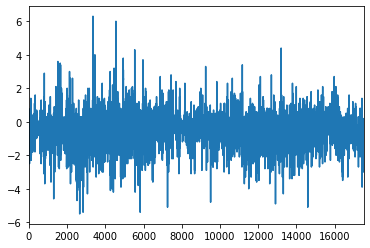

In [8]:
# Check how similar STATIONS 1975 and 1981 are
check_station_differences = temperature_station_1975['TEMPERATURE'].subtract(temperature_station_1981['TEMPERATURE'])

check_station_differences.plot()

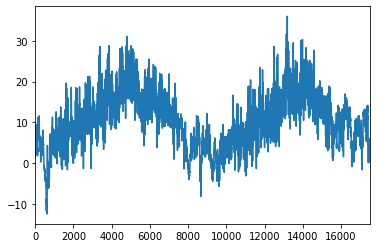

In [9]:
# The values are too far from each other in their maxima (>5 degrees)
# So we will complete the temperature data by taking the average of each station
temperature_data = pd.DataFrame({'DATE' : temperature_station_1975['DATE'],
                                 'TEMPERATURE': (temperature_station_1975['TEMPERATURE']+temperature_station_1975['TEMPERATURE'])/2})

temperature_data['TEMPERATURE'].plot()

In [10]:
#Preciptation Data
#Stations 1975 and 1981
filepath_precipitation_dict = ['precipitation_station_01975.csv','precipitation_station_01981.csv']


#Read the .csv files from the stations 1975 and 1981
precipitation_station_1975 = pd.read_csv(filepath_precipitation_dict[0], sep=';', usecols=[0,1,3])
precipitation_station_1975.columns = ['ID','DATE','PRECIPITATION']


precipitation_station_1981 = pd.read_csv(filepath_precipitation_dict[1], sep=';', usecols=[0,1,3])
precipitation_station_1981.columns = ['ID','DATE','PRECIPITATION']

In [11]:
#Format the Dates from Object to DateTime Types
precipitation_station_1975['DATE'] = pd.to_datetime(precipitation_station_1975['DATE'], format='%Y%m%d%H')
precipitation_station_1981['DATE'] = pd.to_datetime(precipitation_station_1981['DATE'], format='%Y%m%d%H')

In [12]:
#Filter for the Data from 2014-2015
precipitation_station_1975 = precipitation_station_1975[(precipitation_station_1975['DATE'] > date_after) 
                                                        &
                                                        (precipitation_station_1975['DATE'] < date_before)]
precipitation_station_1981 = precipitation_station_1981[(precipitation_station_1981['DATE'] > date_after)
                                                        & 
                                                        (precipitation_station_1981['DATE'] < date_before)]

#Reset indices
precipitation_station_1975.reset_index(drop=True, inplace=True)
precipitation_station_1981.reset_index(drop=True, inplace=True)

In [13]:
# Check for missing values
print('Absolute values missing for station 1975 are: ',
      precipitation_station_1975['PRECIPITATION'][precipitation_station_1975['PRECIPITATION'] == -999.0].count())
print('Absolute values missing for station 1981 are: ',
      precipitation_station_1981['PRECIPITATION'][precipitation_station_1981['PRECIPITATION'] == -999.0].count())


Absolute values missing for station 1975 are:  20
Absolute values missing for station 1981 are:  0


In [14]:
# Handle missing value by just using the other stations data at that exact time
index_of_missing_value = precipitation_station_1975.index[precipitation_station_1975['PRECIPITATION'] ==-999.0]
value = precipitation_station_1981.loc[index_of_missing_value]['PRECIPITATION']
precipitation_station_1975.at[index_of_missing_value, 'PRECIPITATION'] = value


In [15]:
print(len(precipitation_station_1975),len(precipitation_station_1981))

17515 17512


In [16]:
precipitation_merge = pd.merge(precipitation_station_1975, precipitation_station_1981, on='DATE')

In [17]:
precipitation_data = pd.DataFrame({'DATE' : precipitation_merge['DATE'], 
                                   'PRECIPITATION' : (precipitation_merge['PRECIPITATION_x']
                                                      +
                                                      precipitation_merge['PRECIPITATION_y'])/2})

Text(0.5, 1.0, 'Hourly Precipitation')

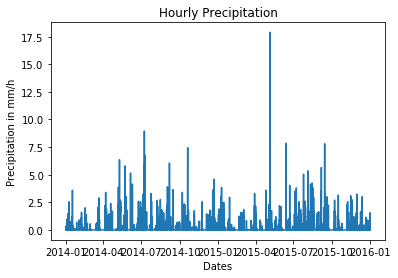

In [18]:
plt.plot(precipitation_data['DATE'], precipitation_data['PRECIPITATION'])
plt.xlabel('Dates')
plt.ylabel('Precipitation in mm/h')
plt.title('Hourly Precipitation')

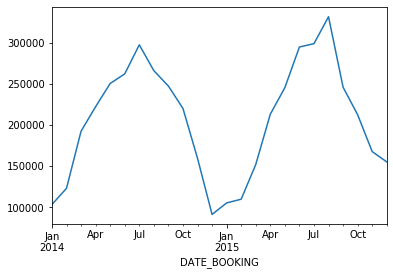

In [19]:
bike_data.index = bike_data['DATE_BOOKING']
monthly_bike_data = bike_data['DATE_BOOKING'].resample('M').count()
daily_bike_data = bike_data['DATE_BOOKING'].resample('D').count()
hourly_bike_data = bike_data['DATE_BOOKING'].resample('H').count()

monthly_bike_data.plot()

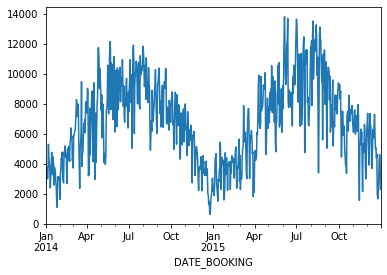

In [20]:
daily_bike_data.plot()

In [21]:
hourly_bike_data

DATE_BOOKING
2014-01-01 00:00:00     90
2014-01-01 01:00:00    115
2014-01-01 02:00:00    128
2014-01-01 03:00:00    160
2014-01-01 04:00:00    154
                      ... 
2015-12-31 19:00:00    175
2015-12-31 20:00:00    104
2015-12-31 21:00:00     86
2015-12-31 22:00:00     51
2015-12-31 23:00:00    131
Freq: H, Name: DATE_BOOKING, Length: 17520, dtype: int64

In [22]:
bike_data['TIME_BOOKED'] = bike_data['DATE_UNTIL'] - bike_data['DATE_FROM']

In [23]:
bike_data.TIME_BOOKED.describe()

count                   4967144
mean     0 days 00:24:26.827739
std      0 days 03:10:34.307310
min             0 days 00:00:01
25%             0 days 00:07:22
50%             0 days 00:12:48
75%             0 days 00:20:53
max            92 days 03:57:55
Name: TIME_BOOKED, dtype: object

In [24]:
time_booked = bike_data.TIME_BOOKED
time_booked.index

DatetimeIndex(['2014-01-01 00:34:54', '2014-01-01 01:39:55',
               '2014-01-01 01:40:20', '2014-01-01 01:56:00',
               '2014-01-01 02:05:55', '2014-01-01 02:29:03',
               '2014-01-01 03:07:07', '2014-01-01 03:12:50',
               '2014-01-01 04:27:51', '2014-01-01 04:58:33',
               ...
               '2015-12-31 19:38:37', '2015-12-31 20:57:37',
               '2015-12-31 23:46:35', '2015-12-31 20:16:35',
               '2015-12-31 20:39:33', '2015-12-31 23:15:08',
               '2015-12-31 23:28:26', '2015-12-31 22:40:18',
               '2015-12-31 23:37:41', '2015-12-31 22:08:26'],
              dtype='datetime64[ns]', name='DATE_BOOKING', length=4967144, freq=None)

In [25]:
data = pd.DataFrame({'DATE' : pd.date_range(start='1/1/2014', end='31/12/2015 23:00:00', freq='H')})

In [26]:
data.index = data.DATE

In [27]:
temperature_data.index = temperature_data['DATE']
precipitation_data.index = precipitation_data['DATE']

In [28]:
data['TEMPERATURE'] = temperature_data['TEMPERATURE']
data['PRECIPITATION'] = precipitation_data['PRECIPITATION']
data['BOOKING_COUNT'] = hourly_bike_data

In [29]:
data

,DATE,TEMPERATURE,PRECIPITATION,BOOKING_COUNT
DATE,,,,
2014-01-01 00:00:00,2014-01-01 00:00:00,2.1,0.0,90
2014-01-01 01:00:00,2014-01-01 01:00:00,2.0,0.0,115
2014-01-01 02:00:00,2014-01-01 02:00:00,2.1,0.0,128
2014-01-01 03:00:00,2014-01-01 03:00:00,1.6,0.0,160
2014-01-01 04:00:00,2014-01-01 04:00:00,1.4,0.0,154
...,...,...,...,...
2015-12-31 19:00:00,2015-12-31 19:00:00,4.4,0.0,175
2015-12-31 20:00:00,2015-12-31 20:00:00,5.0,0.0,104
2015-12-31 21:00:00,2015-12-31 21:00:00,3.8,0.0,86


In [30]:
from sklearn import tree

X = np.array(data.iloc[:,1:3])
Y = np.array(data.iloc[:,3])
X[[np.isnan(X)]] = 0

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

NameError: name 'np' is not defined

In [ ]:
def predict_bike_usage(temperature,precipitation):
    clf.predict()